# PyPath Input Module Analysis Report

This notebook analyzes the categorization results from all 10 groups of PyPath input modules to provide comprehensive insights into the maintenance status, technical characteristics, and biological coverage of the codebase.

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import numpy as np
from pathlib import Path

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Preprocessing

In [2]:
# Load all result files
all_modules = []
group_counts = {}

for i in range(1, 11):
    try:
        with open(f'result-{i}.yaml', 'r') as f:
            data = yaml.safe_load(f)
            if 'modules' in data:
                modules = data['modules']
                print(f"Group {i}: {len(modules)} modules loaded")
                group_counts[i] = len(modules)
                
                # Add group number to each module
                for module in modules:
                    module['group'] = i
                    all_modules.extend([module])
            else:
                print(f"Group {i}: No 'modules' key found in file")
    except FileNotFoundError:
        print(f"Group {i}: File result-{i}.yaml not found")
    except Exception as e:
        print(f"Group {i}: Error loading file - {e}")

print(f"\nTotal modules loaded: {len(all_modules)}")
print(f"Group distribution: {group_counts}")

Group 1: 20 modules loaded
Group 2: 20 modules loaded
Group 3: 20 modules loaded
Group 4: 20 modules loaded
Group 5: 20 modules loaded
Group 6: 20 modules loaded
Group 7: 20 modules loaded
Group 8: 20 modules loaded
Group 9: 20 modules loaded
Group 10: 10 modules loaded

Total modules loaded: 190
Group distribution: {1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 10}


## 2. Basic Statistics

In [3]:
# Extract basic statistics
def extract_field(modules, field_path):
    """Extract nested field values from modules"""
    values = []
    for module in modules:
        try:
            current = module
            for key in field_path.split('.'):
                current = current[key]
            values.append(current)
        except (KeyError, TypeError):
            values.append(None)
    return values

# Create a summary DataFrame
summary_data = {
    'module_name': [m['module_name'] for m in all_modules],
    'group': [m['group'] for m in all_modules],
    'maintenance_category': extract_field(all_modules, 'maintenance_status.category'),
    'module_type': extract_field(all_modules, 'module_type'),
    'dataset_size': extract_field(all_modules, 'dataset_size'),
    'species_coverage': extract_field(all_modules, 'species_coverage'),
    'functions_count': [len(m.get('functions', [])) for m in all_modules]
}

df = pd.DataFrame(summary_data)
print(f"DataFrame shape: {df.shape}")
print(f"\nFirst 5 rows:")
df.head()

DataFrame shape: (190, 7)

First 5 rows:


,module_name,group,maintenance_category,module_type,dataset_size,species_coverage,functions_count
0,transmir,1,infrequent,[primary_data],small,human_only,1
1,lncdisease,1,discontinued,[primary_data],small,multi_species,1
2,icellnet,1,frequent,[primary_data],medium,human_only,3
3,ipi,1,discontinued,[id_mapping],medium,multi_species,1
4,ca1,1,one_time_paper,[primary_data],small,human_only,1


## 3. Maintenance Status Analysis

Maintenance Status Distribution:
  frequent: 79 modules (41.6%)
  infrequent: 46 modules (24.2%)
  discontinued: 43 modules (22.6%)
  one_time_paper: 22 modules (11.6%)


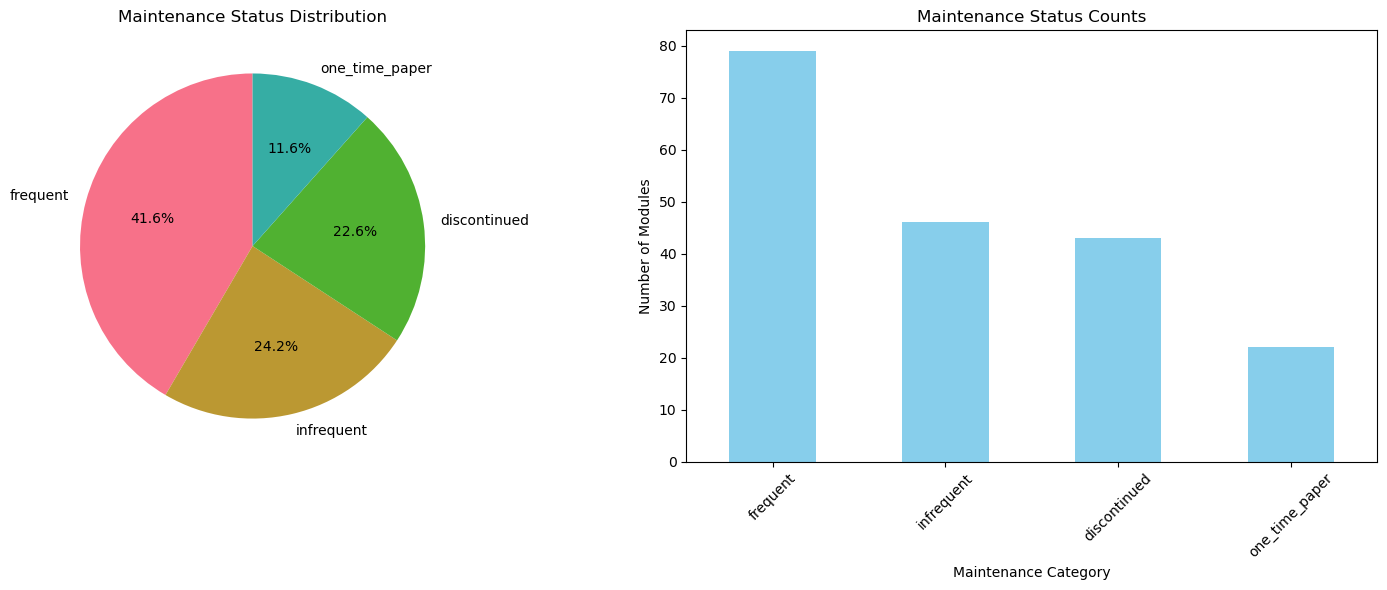

In [4]:
# Maintenance status distribution
maintenance_counts = df['maintenance_category'].value_counts()
print("Maintenance Status Distribution:")
for status, count in maintenance_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {status}: {count} modules ({percentage:.1f}%)")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
maintenance_counts.plot(kind='pie', ax=ax1, autopct='%1.1f%%', startangle=90)
ax1.set_title('Maintenance Status Distribution')
ax1.set_ylabel('')

# Bar chart
maintenance_counts.plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title('Maintenance Status Counts')
ax2.set_xlabel('Maintenance Category')
ax2.set_ylabel('Number of Modules')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Module Type and Dataset Size Analysis

Module Type Distribution:
  primary_data: 162 modules
  utility: 20 modules
  id_mapping: 16 modules
  aggregator: 1 modules

Dataset Size Distribution:
  medium: 71 modules (37.4%)
  large: 67 modules (35.3%)
  small: 52 modules (27.4%)


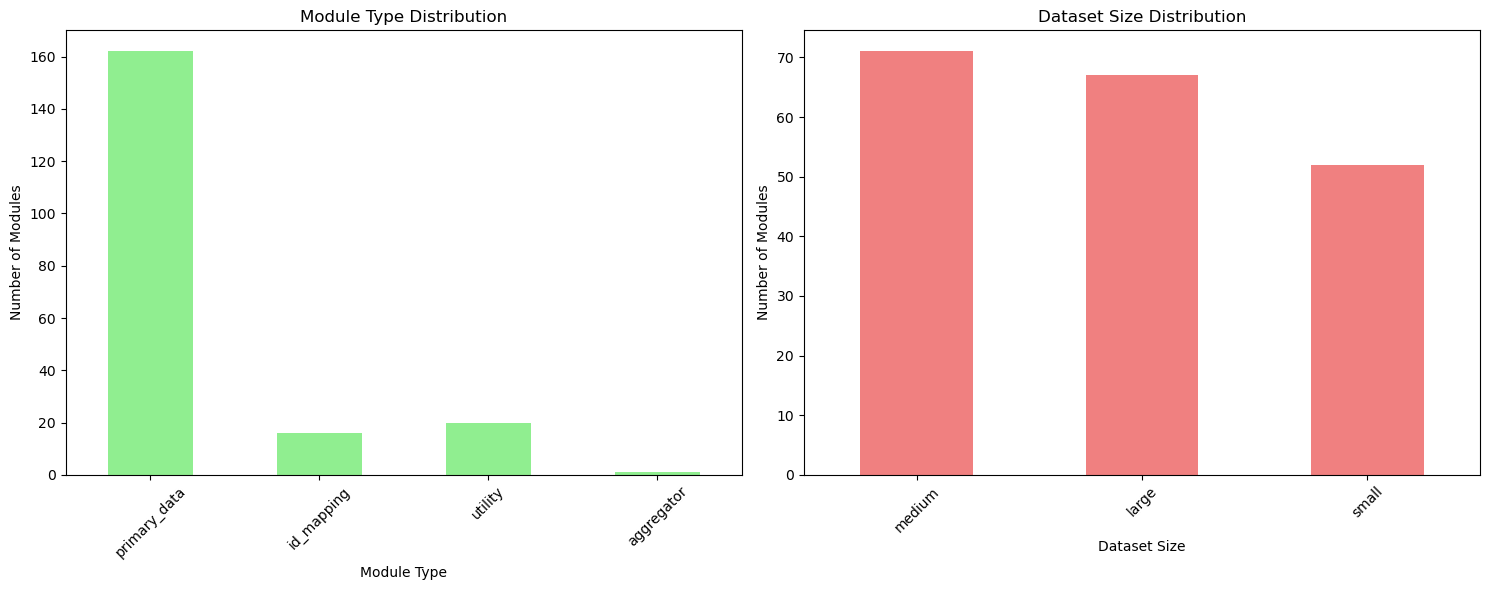

In [5]:
# Module type distribution
module_types = []
for module in all_modules:
    types = module.get('module_type', [])
    if isinstance(types, list):
        module_types.extend(types)
    else:
        module_types.append(types)

module_type_counts = Counter(module_types)
print("Module Type Distribution:")
for mtype, count in module_type_counts.most_common():
    print(f"  {mtype}: {count} modules")

# Dataset size distribution
dataset_size_counts = df['dataset_size'].value_counts()
print("\nDataset Size Distribution:")
for size, count in dataset_size_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {size}: {count} modules ({percentage:.1f}%)")

# Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Module types
pd.Series(module_type_counts).plot(kind='bar', ax=ax1, color='lightgreen')
ax1.set_title('Module Type Distribution')
ax1.set_xlabel('Module Type')
ax1.set_ylabel('Number of Modules')
ax1.tick_params(axis='x', rotation=45)

# Dataset sizes
dataset_size_counts.plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Dataset Size Distribution')
ax2.set_xlabel('Dataset Size')
ax2.set_ylabel('Number of Modules')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Technical Aspects Analysis

Access Method Distribution:
  file_download: 154 modules
  api: 27 modules
  web_scraping: 20 modules
  utility: 1 modules
  file_operations: 1 modules

Top 10 Data Formats:
  tsv: 76 modules
  csv: 28 modules
  zip: 20 modules
  json: 20 modules
  html: 17 modules
  xml: 17 modules
  txt: 15 modules
  xlsx: 13 modules
  xls: 11 modules
  rda: 6 modules


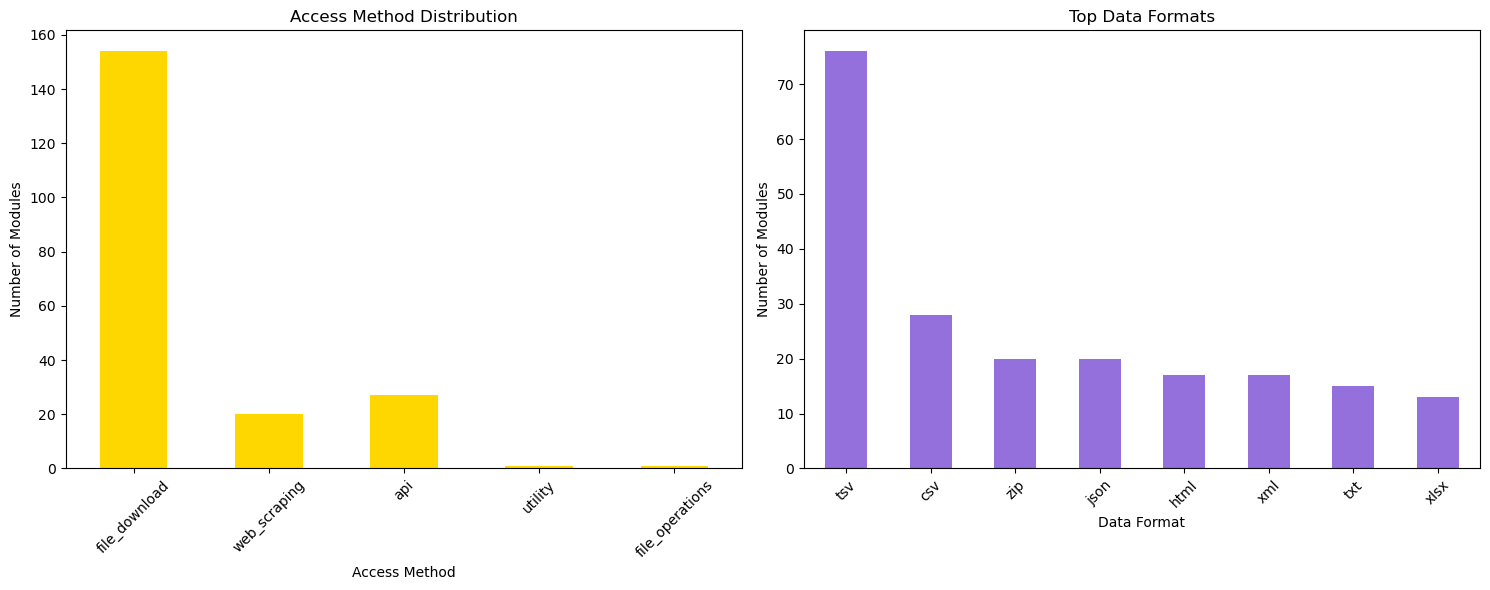

In [6]:
# Access methods
access_methods = []
data_formats = []

for module in all_modules:
    tech_aspects = module.get('technical_aspects', {})
    
    # Access methods
    methods = tech_aspects.get('access_method', [])
    if isinstance(methods, list):
        access_methods.extend(methods)
    else:
        access_methods.append(methods)
    
    # Data formats
    formats = tech_aspects.get('data_format', [])
    if isinstance(formats, list):
        data_formats.extend(formats)
    else:
        data_formats.append(formats)

access_method_counts = Counter([m for m in access_methods if m])
data_format_counts = Counter([f for f in data_formats if f])

print("Access Method Distribution:")
for method, count in access_method_counts.most_common():
    print(f"  {method}: {count} modules")

print("\nTop 10 Data Formats:")
for format_type, count in data_format_counts.most_common(10):
    print(f"  {format_type}: {count} modules")

# Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Access methods
pd.Series(access_method_counts).plot(kind='bar', ax=ax1, color='gold')
ax1.set_title('Access Method Distribution')
ax1.set_xlabel('Access Method')
ax1.set_ylabel('Number of Modules')
ax1.tick_params(axis='x', rotation=45)

# Top data formats
top_formats = dict(data_format_counts.most_common(8))
pd.Series(top_formats).plot(kind='bar', ax=ax2, color='mediumpurple')
ax2.set_title('Top Data Formats')
ax2.set_xlabel('Data Format')
ax2.set_ylabel('Number of Modules')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Biological Entity and Annotation Analysis

In [7]:
# Extract biological tags with module names
from collections import defaultdict

entity_modules = defaultdict(list)
annotation_modules = defaultdict(list)
interaction_modules = defaultdict(list)

for module in all_modules:
    module_name = module.get('module_name', 'unknown')
    tags = module.get('tags', {})
    
    # Entities
    entity_tags = tags.get('entity', [])
    if isinstance(entity_tags, list):
        for entity in entity_tags:
            if entity:
                entity_modules[entity].append(module_name)
    elif entity_tags:
        entity_modules[entity_tags].append(module_name)
    
    # Annotations
    annotation_tags = tags.get('annotation', [])
    if isinstance(annotation_tags, list):
        for annotation in annotation_tags:
            if annotation:
                annotation_modules[annotation].append(module_name)
    elif annotation_tags:
        annotation_modules[annotation_tags].append(module_name)
    
    # Interactions
    interaction_tags = tags.get('interaction', [])
    if isinstance(interaction_tags, list):
        for interaction in interaction_tags:
            if interaction:
                interaction_modules[interaction].append(module_name)
    elif interaction_tags:
        interaction_modules[interaction_tags].append(module_name)

# Count occurrences for sorting
entity_counts = {k: len(v) for k, v in entity_modules.items()}
annotation_counts = {k: len(v) for k, v in annotation_modules.items()}
interaction_counts = {k: len(v) for k, v in interaction_modules.items()}

# Print results
print("Entity Type Distribution:")
for entity, count in sorted(entity_counts.items(), key=lambda x: x[1], reverse=True):
    modules = ', '.join(sorted(entity_modules[entity]))
    print(f"  {entity}: {count} modules ({modules})")

print("\nAnnotation Type Distribution:")
for annotation, count in sorted(annotation_counts.items(), key=lambda x: x[1], reverse=True):
    modules = ', '.join(sorted(annotation_modules[annotation]))
    print(f"  {annotation}: {count} modules ({modules})")

print("\nInteraction Type Distribution:")
for interaction, count in sorted(interaction_counts.items(), key=lambda x: x[1], reverse=True):
    modules = ', '.join(sorted(interaction_modules[interaction]))
    print(f"  {interaction}: {count} modules ({modules})")

# Write results to file
with open('biological_tags_analysis.txt', 'w') as f:
    f.write("PyPath Module Biological Tags Analysis\n")
    f.write("=" * 50 + "\n\n")
    
    f.write("ENTITY TYPE DISTRIBUTION:\n")
    f.write("-" * 30 + "\n")
    for entity, count in sorted(entity_counts.items(), key=lambda x: x[1], reverse=True):
        modules = ', '.join(sorted(entity_modules[entity]))
        f.write(f"{entity}: {count} modules\n")
        f.write(f"  Modules: {modules}\n\n")
    
    f.write("\nANNOTATION TYPE DISTRIBUTION:\n")
    f.write("-" * 30 + "\n")
    for annotation, count in sorted(annotation_counts.items(), key=lambda x: x[1], reverse=True):
        modules = ', '.join(sorted(annotation_modules[annotation]))
        f.write(f"{annotation}: {count} modules\n")
        f.write(f"  Modules: {modules}\n\n")
    
    f.write("\nINTERACTION TYPE DISTRIBUTION:\n")
    f.write("-" * 30 + "\n")
    for interaction, count in sorted(interaction_counts.items(), key=lambda x: x[1], reverse=True):
        modules = ', '.join(sorted(interaction_modules[interaction]))
        f.write(f"{interaction}: {count} modules\n")
        f.write(f"  Modules: {modules}\n\n")

print(f"\nDetailed results written to 'biological_tags_analysis.txt'")

Entity Type Distribution:
  protein: 164 modules (abs, acsn, adhesome, almen2009, baccin2019, biogps, biogrid, biomart, biomodels, ca1, cancercellmap, cancerdrugsdb, cancersea, cellcall, cellcellinteractions, cellchatdb, cellinker, cellphonedb, celltalkdb, celltypist, clinvar, collectri, compath, comppi, connectomedb, cosmic, cpad, cpdb, csa, cspa, ctdbase, cytosig, dbptm, deathdomain, depod, dgidb, dip, diseases, disgenet/_api/schema, disgenet/_api/simple, domino, dorothea, drugbank, drugcentral, ebi, elm, embrace, encode, eutils, exocarta, expasy, genecards, go, gpcrdb, guide2pharma, gutmgene, hgnc, hippie, hmdb/common, hmdb/proteins, hmdb/xml, homologene, hpmr, hpo, hprd, htri, humancellmap, humsavar, huri, i3d, icellnet, ielm, imweb, innatedb, instruct, intact, integrins, interpro, intogen, ipi, iptmnet, italk, kea, kegg, kegg_api, kinasedotcom, kirouac2010, lambert2018, laudanna, li2012, lmpid, lncrnadb, locate, lrdb, macrophage, matrisome, matrixdb, mcam, membranome, mimp, mirdea

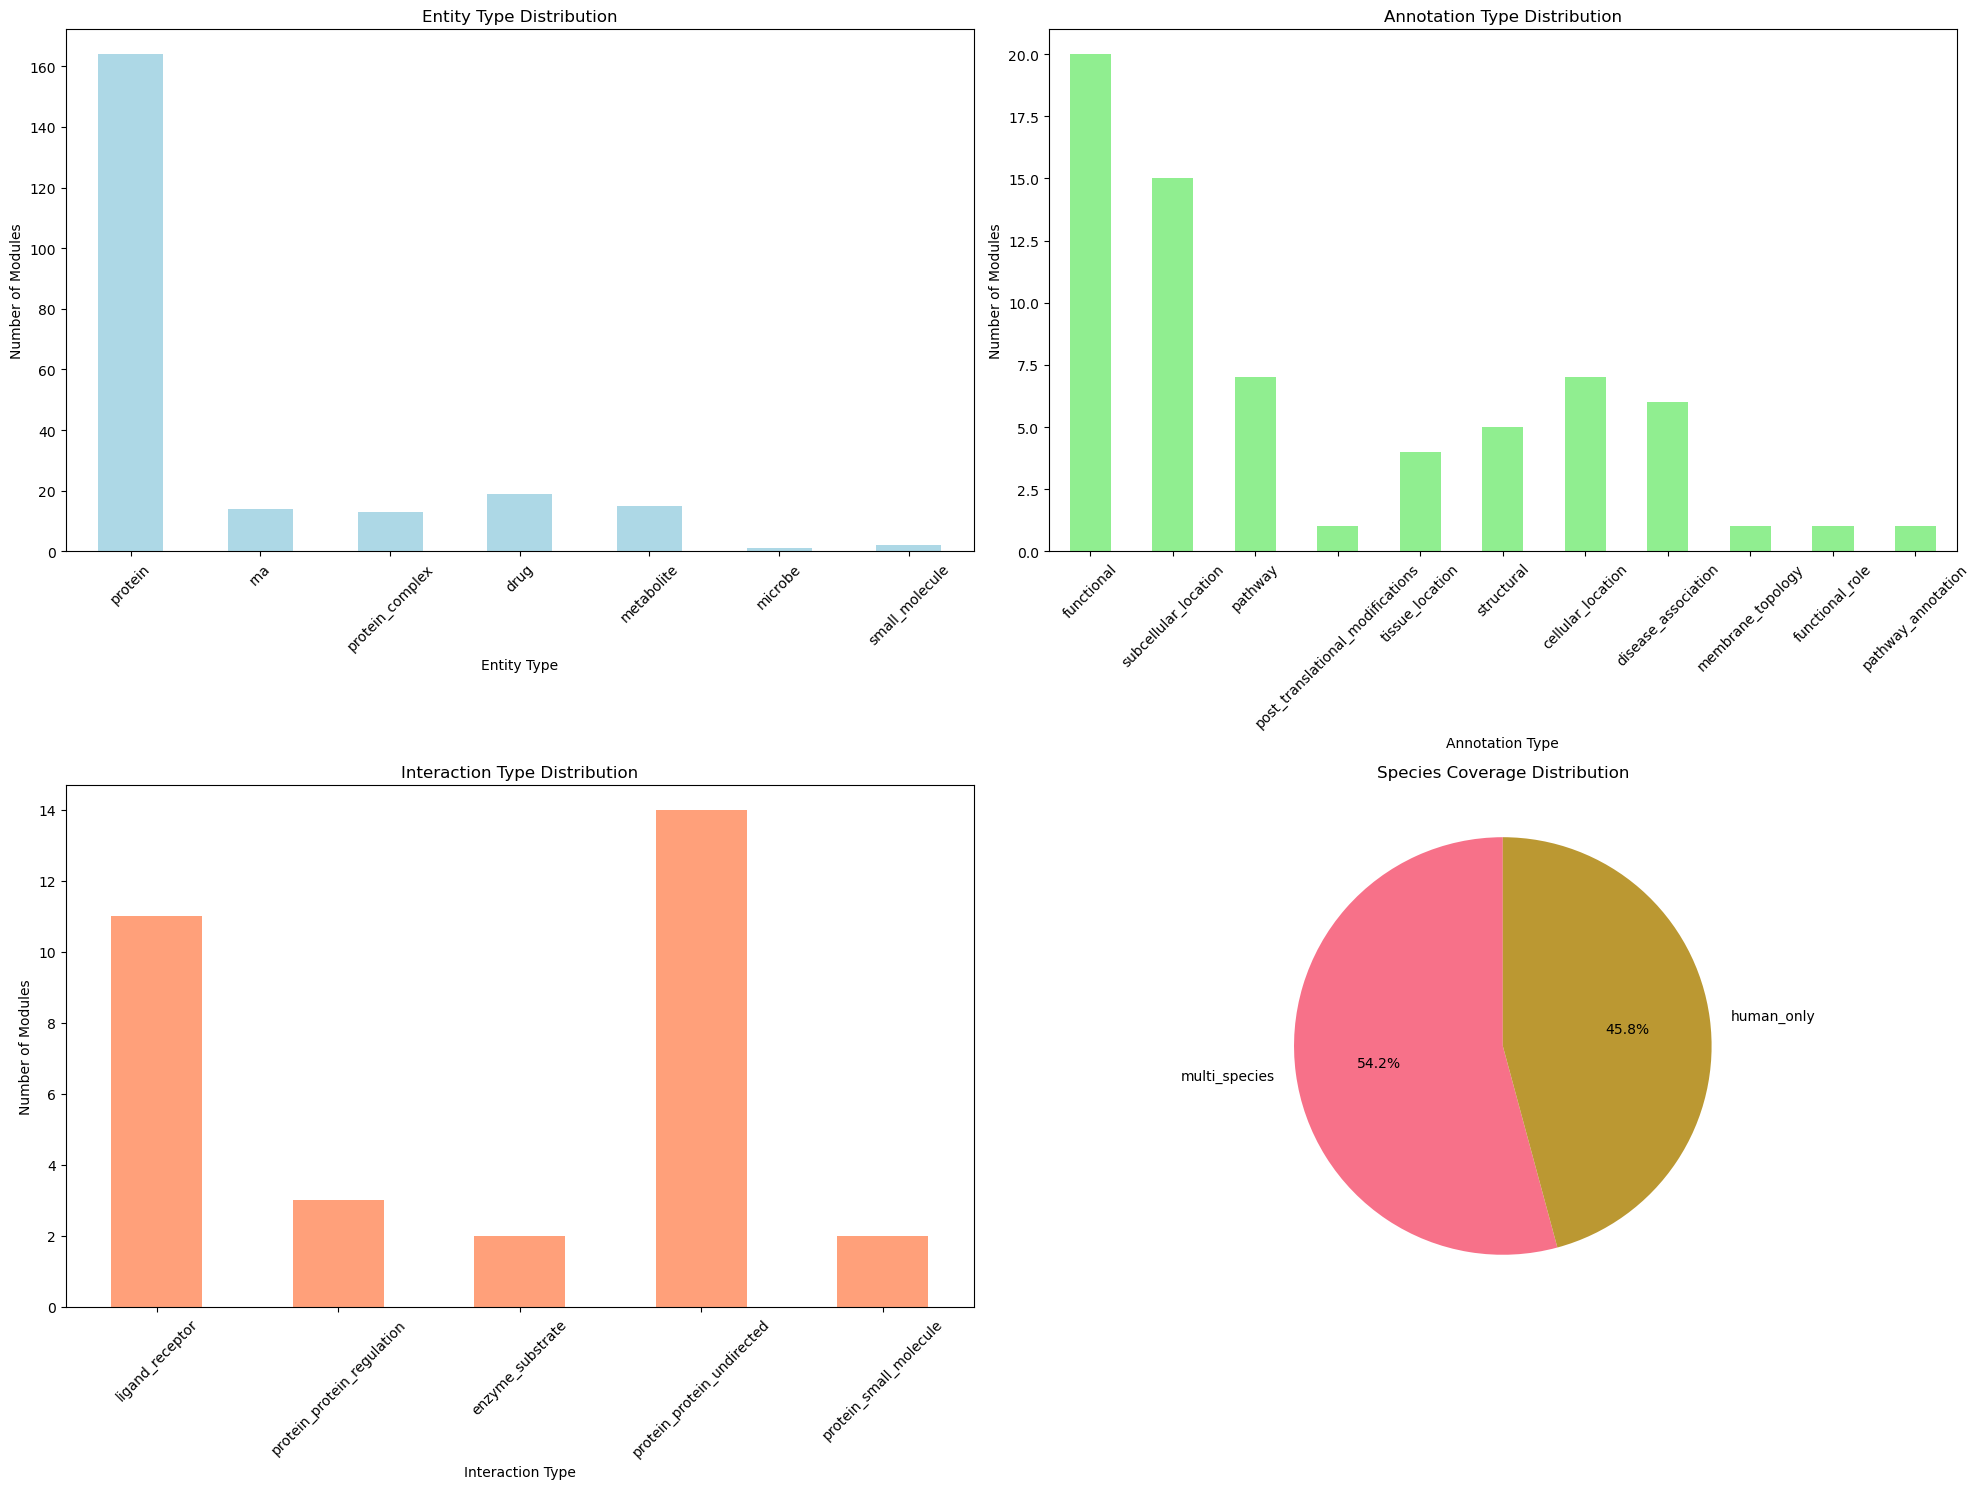

In [8]:
# Visualize biological tags
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Entity types
pd.Series(entity_counts).plot(kind='bar', ax=axes[0,0], color='lightblue')
axes[0,0].set_title('Entity Type Distribution')
axes[0,0].set_xlabel('Entity Type')
axes[0,0].set_ylabel('Number of Modules')
axes[0,0].tick_params(axis='x', rotation=45)

# Annotation types
pd.Series(annotation_counts).plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Annotation Type Distribution')
axes[0,1].set_xlabel('Annotation Type')
axes[0,1].set_ylabel('Number of Modules')
axes[0,1].tick_params(axis='x', rotation=45)

# Interaction types
pd.Series(interaction_counts).plot(kind='bar', ax=axes[1,0], color='lightsalmon')
axes[1,0].set_title('Interaction Type Distribution')
axes[1,0].set_xlabel('Interaction Type')
axes[1,0].set_ylabel('Number of Modules')
axes[1,0].tick_params(axis='x', rotation=45)

# Species coverage
species_counts = df['species_coverage'].value_counts()
species_counts.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Species Coverage Distribution')
axes[1,1].set_ylabel('')

plt.tight_layout()
plt.show()